# Exercise Lecture 4

The block of code below downloads data from the yfinance library. Instead of using `your_stock` use the acronym of the stock that has been assigned to you.

Running the code you will store the log-returns of your stock for the period 2022-2024. Do not change this overall setup.

You may notice the code is slightly different from the other notebooks. This is to avoid warnings on how dates are handled.

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fetch BIDU stock data
data = yf.download('BIDU', start='2022-01-01', end='2024-12-31')

# Select 'Close' prices and calculate log returns
data_close = data['Close'].ffill()

data_log_returns = np.log(data_close / data_close.shift(1)).dropna() * 100
data_log_returns.index = pd.to_datetime(data_log_returns.index)

# Set the frequency to daily ('D')
data_log_returns = data_log_returns.asfreq('D')



[*********************100%***********************]  1 of 1 completed


# Exercise 1

Plot the time series of the log-returns and compute a test to check if the series is stationary. What are your conclusions?


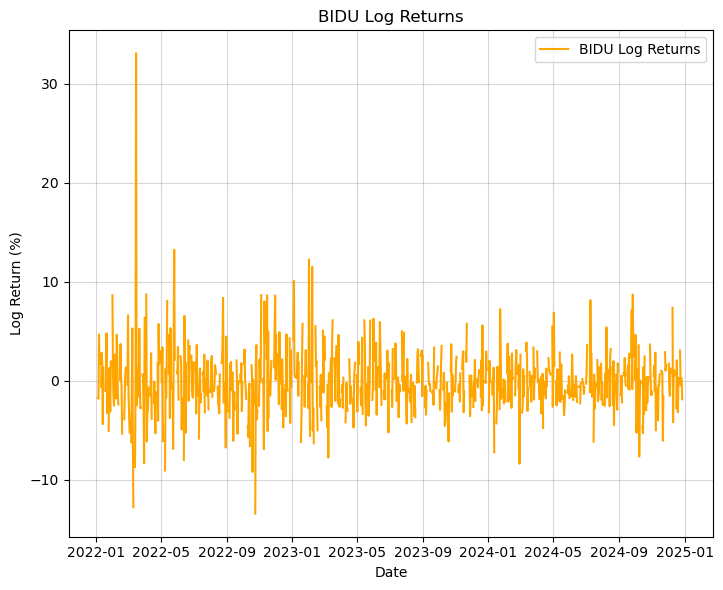

In [8]:
import matplotlib.pyplot as plt

# Plot original time series and log returns
plt.figure(figsize=(14, 6))

# Plot log returns
plt.subplot(1, 2, 2)
plt.plot(data_log_returns, label='BIDU Log Returns', color='orange')
plt.title('BIDU Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('bidu_prices_log_returns.png', dpi=300)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
data_log_returns = data_log_returns.fillna(method='ffill') 
result = adfuller(data_log_returns)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')
if result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

ADF Statistic: -11.760140081311707
p-value: 1.1532121265061663e-21
Critical Values: {'1%': -3.4363857496063455, '5%': -2.8642050392821794, '10%': -2.5681889563132314}
Reject the null hypothesis: The series is stationary.


C:\Users\tinyellow\AppData\Local\Temp\ipykernel_11340\1765499981.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_log_returns = data_log_returns.fillna(method='ffill')


From the series of log returns, we can see that the BIDU log return is stationary with low volatility.
The test also rejects the null hypothesis and is significant at a 1% level, showing the log return of BIDU is stationary during the backtest period.

# Exercise 2

Compute the ACF and PACF plots. Comment on their appearance. What AR model would they seem to suggest to use and why?

<Figure size 1000x600 with 0 Axes>

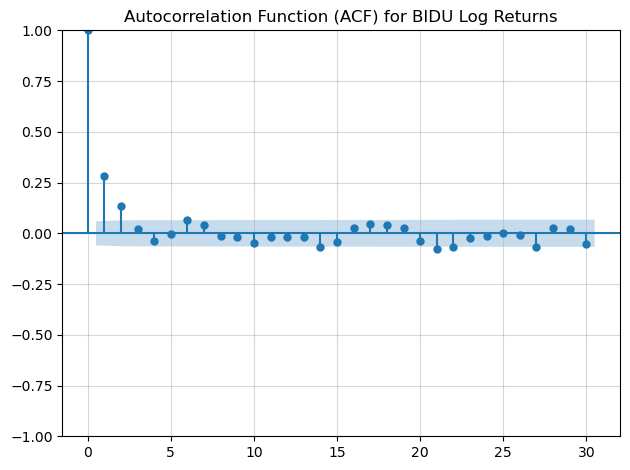

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF for BIDU log-returns
plt.figure(figsize=(10, 6))
plot_acf(data_log_returns, lags=30, title='Autocorrelation Function (ACF) for BIDU Log Returns')
plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot
plt.savefig('acf_plot.png', dpi=300)
plt.show()

<Figure size 1000x600 with 0 Axes>

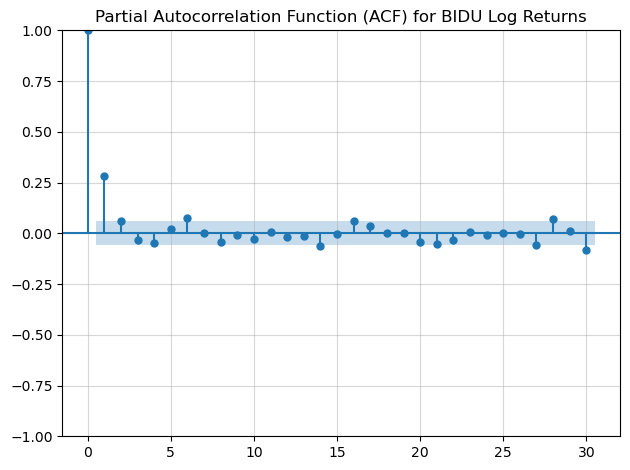

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Plot PACF for BIDU
plt.figure(figsize=(10, 6))
plot_pacf(data_log_returns, lags=30, title='Partial Autocorrelation Function (ACF) for BIDU Log Returns')
plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot
plt.savefig('pacf_plot.png', dpi=300)
plt.show()

The ACF shows a sharp drop after lag 1, with the remaining lags falling within the confidence bounds. This suggests that the autocorrelation is primarily significant at lag 1.
The PACF shows a sharp cutoff at lag 1, similar to ACF. This indicates that the partial autocorrelation is largely explained by the first lag.
An AR(1) model is appropriate for this data because the ACF and PACF patterns point to a strong dependence only at the first lag.



# Exercise 3

Fit your chosen AR model. Comment on all relevant elements of the output.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) model
ar1_model = ARIMA(data_log_returns, order=(1, 0, 0)).fit()

# Display summaries
print("AR(1) Model Summary:\n", ar1_model.summary())

AR(1) Model Summary:
                                SARIMAX Results                                
Dep. Variable:                   BIDU   No. Observations:                 1092
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2782.258
Date:                Thu, 23 Jan 2025   AIC                           5570.515
Time:                        03:07:33   BIC                           5585.502
Sample:                    01-04-2022   HQIC                          5576.187
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1651      0.138     -1.197      0.231      -0.435       0.105
ar.L1          0.2822      0.017     16.802      0.000       0.249       0.315
sigma2         9.5614      0.1

AR Lag 1: The lag-1 autoregressive coefficient is statistically significant (p < 0.05). This confirms the importance of the AR(1) term in explaining the series' dynamics.
Ljung-Box Q-test: The high p-value (> 0.05) indicates no significant autocorrelation in the residuals at lag 1, suggesting the model sufficiently captures the autocorrelation structure.
Heteroskedasticity (H) Test: H-statistic: 0.34. No significant heteroskedasticity is detected, indicating that the residuals have constant variance.
Jarque-Bera (JB) Test: The low p-value (0.00) suggests the residuals are not normally distributed. This might imply heavy tails or skewness in the data.
Positive skew (1.25) indicates that the residuals have a longer tail on the right side.
High kurtosis (16.38) suggests the presence of heavy tails, which deviates from the normality assumption.

# Exercise 4

Create the diagnostic plots for your AR model and comment on their appearance.


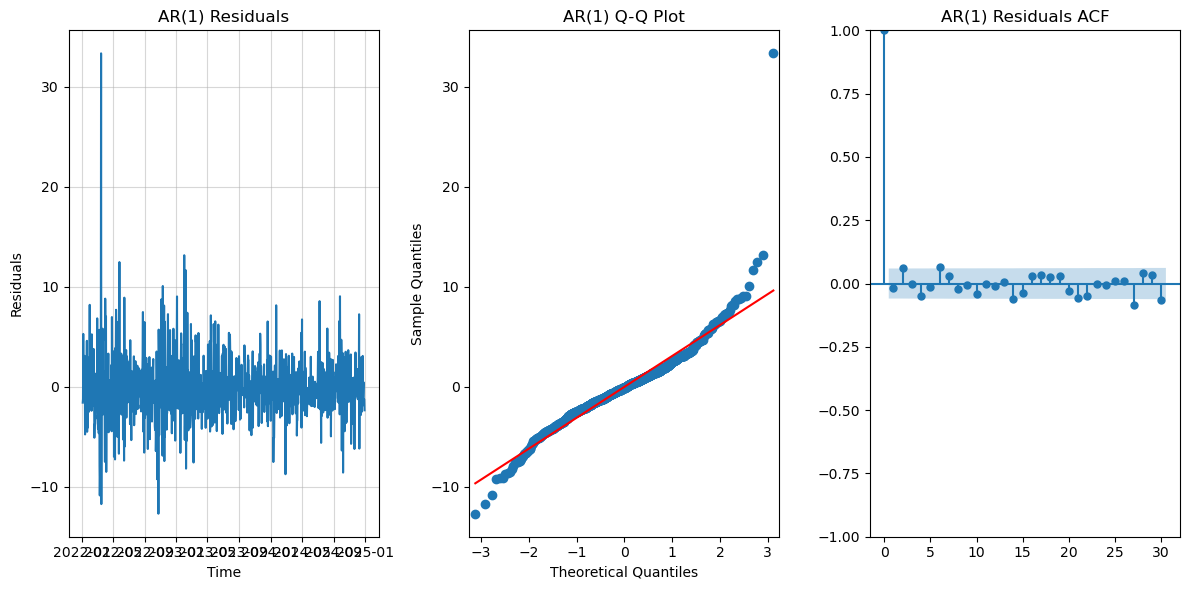

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create a figure for residual plots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Residual plot
axes[0].plot(ar1_model.resid)
axes[0].set_title('AR(1) Residuals')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(alpha=0.5)

# Q-Q Plot
sm.qqplot(ar1_model.resid, line='s', ax=axes[1])
axes[1].set_title('AR(1) Q-Q Plot')

# ACF Plot
plot_acf(ar1_model.resid, lags=30, ax=axes[2])
axes[2].set_title('AR(1) Residuals ACF')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('ar1_residuals.png', dpi=300)
plt.show()

Time series of residuals show a discernible pattern or trend over time, which does not look like 
white nois.)▶ ThQQ q-plot of the residualdoes not s agree with thnormalen distributi.oResiduals ACF have no significant autocorrelations.ion